# Project: Taxi Ride Duration

## 1. Problem statement

We will have to solve a real machine learning problem aimed at automating business processes. We will build a model that will predict the total duration of a taxi ride in New York.

Imagine you order a taxi from one point in New York to another, and the end point does not necessarily have to be within the city. How much will you have to pay for it? It is known that the cost of a taxi in the USA is calculated based on a fixed rate + a tariff cost, the amount of which depends on time and distance. Tariffs vary depending on the city.

In turn, the travel time depends on many factors such as where you are going from and to, what time of day you are making your trip, weather conditions, and so on.

Thus, if we develop an algorithm that can determine the duration of a trip, we will be able to predict its cost in the most trivial way, for example, simply multiplying the cost by a given tariff.
Taxi services store huge amounts of information about trips, including data such as the starting/final point of the route, the date of the trip and its duration. This data can be used to predict the duration of a trip automatically using artificial intelligence.

**Business task:** determine the characteristics and use them to predict the duration of a taxi trip.

**Technical task for you as a Data Science specialist:** build a machine learning model that will predict a numerical feature - taxi trip time - based on the proposed client characteristics. That is, solve the regression problem.

**Main goals of the project:**
1. Create a data set based on several sources of information
2. Design new features using Feature Engineering and identify the most significant ones when building a model
3. Explore the provided data and identify patterns
4. Build several models and select the best one for a given metric
5. Design a process for predicting the duration of a trip for new data

During the project, you will practice working with multiple data sources, feature generation, exploratory data analysis and visualization, feature selection, and of course, building machine learning models!

## 2. Getting to Know the Data, Basic Analysis, and Data Extension

Let's start our research by getting acquainted with the provided data. We will also load additional data sources and expand our initial dataset.

We import in advance the modules that we will need to solve the problem:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
import sys

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

sys.path.append('../../')


Let's read our file with the initial data:

In [2]:
taxi_data = pd.read_csv("../../data/train-taxi-ride.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


So, we have data on almost 1.5 million trips and 11 characteristics that describe each of the trips.

We have conditionally divided the features into several groups. We will further pay special attention to each of the groups.

**Client and fleet data:**
* id - unique trip identifier
* vendor_id - unique identifier of the vendor (taxi fleet) associated with the trip record

**Temporal characteristics:**
* pickup_datetime - date and time when the trip counter was turned on
* dropoff_datetime - date and time when the counter was turned off

**Geographical information:**
* pickup_longitude - longitude at which the counter was turned on
* pickup_latitude - latitude at which the counter was turned on
* dropoff_longitude - longitude at which the counter was turned off
* dropoff_latitude - latitude at which the counter was turned off

**Other features:**
* passenger_count - number of passengers in the vehicle (value entered by the driver)
* store_and_fwd_flag - flag that indicates whether the trip record was saved in the vehicle's memory before sending it to the vendor. Y - store and forward, N - do not store and do not forward the trip.

**Target attribute:**
* trip_duration - trip duration in seconds

To begin, we will conduct a basic analysis of how ready the data is for further pre-processing and analysis.

### Task 2.1
First, let's look at the time frame in which we work with the data.

Translate the pickup_datetime attribute into the datetime data type with the format year-month-day hour:minute:second.

Determine the time frame (excluding time) for which the data is presented.

In [3]:
taxi_data['pickup_dt'] = pd.to_datetime(taxi_data['pickup_datetime'])

print('Timeframe start:', taxi_data['pickup_dt'].min())
print('Timeframe end:', taxi_data['pickup_dt'].max())

Timeframe start: 2016-01-01 00:00:17
Timeframe end: 2016-06-30 23:59:39


### Task 2.2
Let's look at the empty values.
How many empty values ​​are present in the data (total for all columns of the table)?

In [4]:
taxi_data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
pickup_dt             0
dtype: int64

### Task 2.3
Let's look at the statistical characteristics of some features.

a) How many unique taxi companies are present in the data?

b) What is the maximum number of passengers?

c) What is the mean and median trip duration? Give your answer in seconds and round to the nearest whole number.

d) What is the minimum and maximum trip time (in seconds)?

In [5]:
# a
print('Number of unique taxi companies:', taxi_data['vendor_id'].nunique())

# b
print('Maximum number of passengers:', taxi_data['passenger_count'].max())

# c
print('Mean trip duration:', taxi_data['trip_duration'].mean().round())
print('Median trip duration:', taxi_data['trip_duration'].median().round())

# d
print('Minimum trip duration:', taxi_data['trip_duration'].min())
print('Maximum trip duration:', taxi_data['trip_duration'].max())


Number of unique taxi companies: 2
Maximum number of passengers: 9
Mean trip duration: 959.0
Median trip duration: 662.0
Minimum trip duration: 1
Maximum trip duration: 3526282


Let's expand the original data set both with the help of external sources and with the help of manipulations of the features present in the data.

### Task 2.4
Implement the add_datetime_features() function that takes a table with trip data (DataFrame) as input and returns the same table with 3 columns added to it:
* pickup_date - the date the counter was turned on - the start of the trip (without time);
* pickup_hour - the hour of the day the counter was turned on;
* pickup_day_of_week - the ordinal number of the day of the week (number) on which the counter was turned on.

a) How many trips were made on Saturday?

b) How many trips are made on average per day? Round your answer to the nearest whole number

In [6]:
def add_datetime_features(df):
    df['pickup_date'] = df['pickup_dt'].dt.date
    df['pickup_hour'] = df['pickup_dt'].dt.hour
    df['pickup_day_of_week'] = df['pickup_dt'].dt.dayofweek

    return df


taxi_data = add_datetime_features(taxi_data)

# a
print('Number of taxi rides on Saturdays:', taxi_data[taxi_data['pickup_day_of_week']==5].shape[0])

# b
print('Mean rides per day:', taxi_data.groupby('pickup_date')['id'].agg('count').mean().round())

Number of taxi rides on Saturdays: 220868
Mean rides per day: 8015.0


### Task 2.5
Implement the add_holiday_features() function that takes two tables as input:
* a table with trip data;
* a table with holiday data;

and returns an updated table with trip data with a pickup_holiday column added to it - a binary indicator of whether the trip started on a holiday or not (1 - yes, 0 - no).

What is the median duration of a taxi trip on holidays? Give your answer in seconds, rounded to the nearest whole number.

In [7]:
holiday_data = pd.read_csv('../../data/holiday_data.csv', sep=';')
holiday_data['date'] = pd.to_datetime(holiday_data['date']).dt.date
holiday_data = holiday_data.drop(['day', 'holiday'], axis=1)
holiday_data['pickup_holiday'] = 1


def add_holiday_features(df_trip, df_holiday):
    df_merged = df_trip.merge(right=df_holiday, how='left', left_on='pickup_date', right_on='date')
    df_merged = df_merged.drop('date', axis=1)
    return df_merged


taxi_data = add_holiday_features(taxi_data, holiday_data)
taxi_data['pickup_holiday'] = taxi_data['pickup_holiday'].apply(lambda x: x if x == 1 else 0)

print('Median taxi trip duration on holidays:', taxi_data[taxi_data['pickup_holiday']==1]['trip_duration'].median().round())

Median taxi trip duration on holidays: 585.0


### Task 2.6
Implement the add_osrm_features() function that takes two tables as input:
* table with trip data;
* table with data from OSRM;

and returns an updated table with trip data with 3 columns added to it:
* total_distance;
* total_travel_time;
* number_of_steps.

a) What is the difference (in seconds) between the median trip duration in the data and the median trip duration obtained from OSRM?

As a result of merging the tables, you should have gaps in the columns with information from the OSRM API. This is due to the fact that for some trips it was not possible to download data from the web source.

b) How many gaps are there in the columns with information from the OSRM API after merging the tables?

In [8]:
osrm_data = pd.read_csv('../../data/osrm_data_train_taxi.csv')
osrm_data = osrm_data[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]


def add_osrm_features(df_trip, df_osrm):
    df_merged = df_trip.merge(right=df_osrm, how='left')
    
    return df_merged


taxi_data = add_osrm_features(taxi_data, osrm_data)

# a
median_trip_duration = taxi_data['trip_duration'].median()
median_duration_osrm = taxi_data['total_travel_time'].median()
print('Difference between real and osrm duration:', round(median_trip_duration - median_duration_osrm))

# b
print('The following number of records contain empty values:')
taxi_data.isnull().sum()

Difference between real and osrm duration: 372
The following number of records contain empty values:


id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
pickup_dt             0
pickup_date           0
pickup_hour           0
pickup_day_of_week    0
pickup_holiday        0
total_distance        1
total_travel_time     1
number_of_steps       1
dtype: int64

In [9]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # convert angles to radians
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # earth radius in kilimeters
    EARTH_RADIUS = 6371 
    # calculate the shortest distance h using the Haversine formula
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h


def get_angle_direction(lat1, lng1, lat2, lng2):
    # convert angles to radians
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # calculate the angle of the direction of movement alpha using the bearing angle formula
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

### Task 2.7.
Implement the add_geographical_features() function that takes a table of trip data as input and returns an updated table with 2 columns added to it:
* haversine_distance - the Haversine distance between the point where the meter was turned on and the point where the meter was turned off;
* direction - the direction of travel from the point where the meter was turned on to the point where the meter was turned off.

What is the median Haversine distance of trips (in kilometers)? Round your answer to hundredths.

In [10]:
def add_geographical_features(df_trip):
    df_trip['haversine_distance'] = df_trip.apply(lambda x: get_haversine_distance(
        x['pickup_latitude'], x['pickup_longitude'],
        x['dropoff_latitude'], x['dropoff_longitude']
    ), axis=1)
    df_trip['direction'] = df_trip.apply(lambda x: get_angle_direction(
        x['pickup_latitude'], x['pickup_longitude'],
        x['dropoff_latitude'], x['dropoff_longitude']
    ), axis=1)
    
    return df_trip


taxi_data = add_geographical_features(taxi_data)

print('Median Haversine distance:', taxi_data['haversine_distance'].median().round(2))

Median Haversine distance: 2.09


### Task 2.8.
Implement the add_cluster_features() function that takes a table of trip data and a trained clustering algorithm as input. The function should return an updated table with the geo_cluster column added to it - the geographic cluster to which the trip belongs.

How many trips are contained in the smallest geographic cluster?

In [11]:
def add_cluster_features(df_trip, kmeans):
    df_trip['geo_cluster'] = kmeans.predict(df_trip[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']])
    
    return df_trip


# train clusterization model
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(taxi_data[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']])

taxi_data = add_cluster_features(taxi_data, kmeans)
print('Number of trips in the smallest geographic cluster:', taxi_data['geo_cluster'].value_counts().values[-1])

Number of trips in the smallest geographic cluster: 2


### Task 2.9.
Implement the add_weather_features() function that takes two tables as input:
* a table with trip data;
* a table with hourly weather data;

and returns an updated table with trip data with 5 columns added to it:
* temperature;
* visibility;
* wind speed;
* precip;
* events.

a) How many trips were made in snowy weather?

As a result of the merge, you should get records for which there will be empty values in the temperature, visibility, wind speed, precip, and events columns. This is due to the fact that the table with weather data is missing measurements for some points in time at which the trip counter was turned on.

b) What percent of the total number of observations in the table with trip data are empty values in the weather columns? Give your answer to the hundredths of a percent.

In [12]:
def add_weather_features(df_trip, df_weather):
    df_weather['time'] = pd.to_datetime(df_weather['time'])
    df_weather['date'] = df_weather['time'].dt.date
    df_weather['hour'] = df_weather['time'].dt.hour
    df_weather['events'] = df_weather['events'].apply(lambda x: 'None' if pd.isnull(x) else x)

    df_weather = df_weather.drop(['time', 'windchill', 'heat index', 
                                   'humidity', 'pressure', 'dew Point', 
                                   'wind dir', 'gust speed', 'conditions'],
                                 axis=1)

    df_trip = pd.merge(left=df_trip, right=df_weather, how='left', left_on=['pickup_date', 'pickup_hour'], right_on=['date', 'hour'])
    df_trip = df_trip.drop(['date', 'hour'], axis=1)
    
    return df_trip


weather_data = pd.read_csv('../../data/weather_data.csv')

taxi_data = add_weather_features(taxi_data, weather_data)

# a
print('Number of taxi rides in different weather conditions:', taxi_data['events'].value_counts())

# b
empty_weather_count = taxi_data.isnull().sum().values[-1]
empty_weather_ratio = 100 * empty_weather_count / taxi_data.shape[0]
print(f'Percent of empty weather values: {empty_weather_ratio:.2f}')

Number of taxi rides in different weather conditions: events
None    1375185
Rain      58300
Snow      13126
Fog           1
Name: count, dtype: int64
Percent of empty weather values: 0.82


### Task 2.10.
Implement the fill_null_weather_data() function, which takes a table with trip data as input. The function should fill in missing values ​​in the columns.

Fill in the empty values in the columns with weather conditions - temperature, visibility, wind speed, precip with the median value of temperature, visibility, wind speed and precip depending on the start date of the trip. To do this, group the data by the pickup_date column and calculate the median in each group, then fill in the emtpy values using a combination of the transform() and fillna() methods.

Fill in the empty values in the events column with the string 'None' - a symbol for the absence of weather phenomena (snow/rain/fog).

Fill in the gaps in the columns with information from the OSRM API - total_distance, total_travel_time and number_of_steps with the median value by column.

What is the median in the temperature column after filling in the blanks? Round your answer to tenths.

In [13]:
def fill_null_weather_data(df_trip):
    df_trip['temperature'] = df_trip['temperature'].fillna(df_trip.groupby('pickup_date')['temperature'].transform('median'))
    df_trip['visibility'] = df_trip['visibility'].fillna(df_trip.groupby('pickup_date')['visibility'].transform('median'))
    df_trip['wind speed'] = df_trip['wind speed'].fillna(df_trip.groupby('pickup_date')['wind speed'].transform('median'))
    df_trip['precip'] = df_trip['precip'].fillna(df_trip.groupby('pickup_date')['precip'].transform('median'))
    df_trip['events'] = df_trip['events'].fillna('None')
    
    return df_trip


taxi_data = fill_null_weather_data(taxi_data)
taxi_data['total_distance'] = taxi_data['total_distance'].fillna(taxi_data['total_distance'].median())
taxi_data['total_travel_time'] = taxi_data['total_travel_time'].fillna(taxi_data['total_travel_time'].median())
taxi_data['number_of_steps'] = taxi_data['number_of_steps'].fillna(taxi_data['number_of_steps'].median())

print('Median temperature value:', taxi_data['temperature'].median().round(1))

Median temperature value: 11.1


In conclusion of the first part, let's find obvious outliers in the target variable - trip duration.

The easiest way is to find trips that are too long. Let's agree that outliers will be trips that last longer than 24 hours.

It's a little more difficult to analyze trips that are too short. Because there are real short-distance trips, trips that were canceled a second after the meter started, and "teleportations" - moving for long distances in a matter of seconds.

Let's agree that we will consider only the last group as outliers. How can we detect them in the simplest way?

We can use information about the shortest distance that a taxi travels. Calculate the average speed of a car on the shortest route as follows:
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
If we plot a scatter plot of the average speed of cars, we will see the following picture:

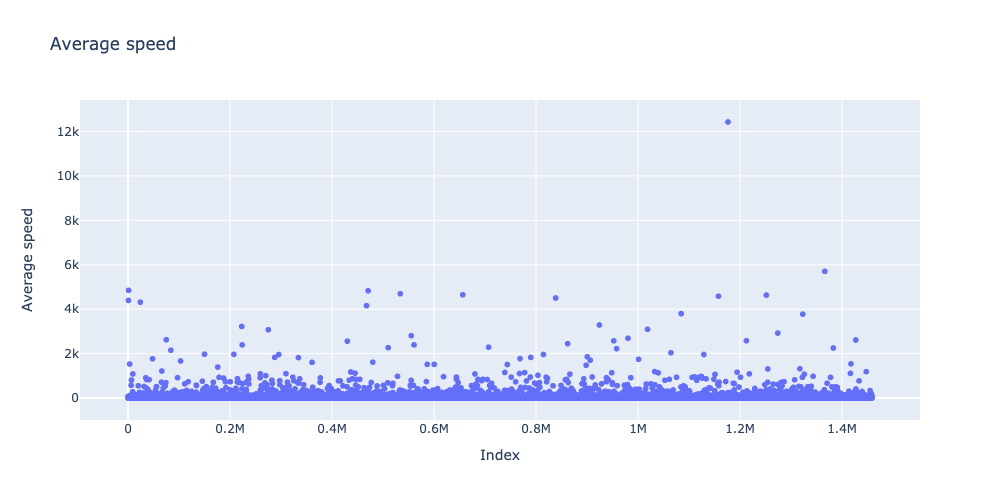

In [34]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6

fix = px.scatter(
    avg_speed,
    width=1000,
    height=500,
    title='Average speed'
).update_layout(
    showlegend=False,
    yaxis_title='Average speed',
    xaxis_title='Index'
)
fix.show('png')

We see that we have “teleportation trips” for which the average speed is over 1000 km/h. There is even one whose average speed was over 12,000 km/h!

Let’s agree that the maximum average speed that taxi drivers can reach is 300 km/h.

### Task 2.11.
Find trips that last longer than 24 hours. And remove them from the dataset.

a) How many trip duration outliers did you find?

Find trips that have an average speed above 300 km/h on the shortest route and remove them from the data.

b) How many speed outliers did you find?

In [45]:
# a 
outliers_24h = taxi_data[taxi_data['trip_duration']>60*60*24]
print('Trips that last longer than 24 hours:', outliers_24h.shape[0])
taxi_data = taxi_data.drop(outliers_24h.index, axis=0)

# b
outliers_300kmh = taxi_data[taxi_data['total_distance']/taxi_data['trip_duration']*3.6>300]
print(
    'Trips that have average speed above 300 km/h:', 
    outliers_300kmh.shape[0]
)
taxi_data = taxi_data.drop(outliers_300kmh.index, axis=0)

Trips that last longer than 24 hours: 4
Trips that have average speed above 300 km/h: 407


## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы с вами:
* Исследуем сформированный набор данных; 
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование. Постарайтесь оформлять диаграммы с душой, а не «для галочки»: навыки визуализации полученных выводов обязательно пригодятся вам в будущем.


Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [18]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

### Задание 3.1.
Постройте гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log). 
Исходя из визуализации, сделайте предположение, является ли полученное распределение нормальным? 
Проверьте свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$. 

а) Чему равен вычисленный p-value? Ответ округлите до сотых.

б) Является ли распределение длительности поездок в логарифмическом масштабе нормальным?

In [19]:
# ваш код здесь

### Задание 3.2.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id). 

Сравните два распределения между собой.

In [20]:
# ваш код здесь

### Задание 3.3.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag). 

Сравните два распределения между собой.

In [21]:
# ваш код здесь

### Задание 3.4.
Постройте две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

На основе построенных графиков ответьте на следующие вопросы:

а) В какое время суток такси заказывают реже всего?

б) В какое время суток наблюдается пик медианной длительности поездок?

In [22]:
# ваш код здесь

### Задание 3.5.
Постройте две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

На основе построенных графиков ответьте на следующие вопросы:
а) В какой день недели совершается больше всего поездок?
б) В какой день недели медианная длительность поездок наименьшая?


In [23]:
# ваш код здесь

### Задание 3.6.
Посмотрим на обе временные характеристики одновременно. 

Постройте сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration). 

Визуализируйте полученную сводную таблицу с помощью тепловой карты (рекомендуемая палитра - coolwarm).

In [24]:
# ваш код здесь

### Задание 3.7.
Постройте две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложите широту (longitude), а по оси ординат - долготу (latitude). 
Включите в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавьте следующие ограничения на границы осей абсцисс и ординат:
 
city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавьте на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее. 

**Рекомендация:** для наглядности уменьшите размер точек на диаграмме рассеяния.  


In [25]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

# ваш код здесь

## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [26]:
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458644, 28)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_dt', 'pickup_date', 'pickup_hour',
       'pickup_day_of_week', 'pickup_holiday', 'total_distance',
       'total_travel_time', 'number_of_steps', 'haversine_distance',
       'direction', 'geo_cluster', 'temperature', 'visibility', 'wind speed',
       'precip', 'events', 'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [27]:
train_data = taxi_data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_dt,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14 17:24:55,2016-03-14,17,0,0.0,2009.1,164.9,5.0,1.498521,99.970196,6,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12 00:43:35,2016-06-12,0,6,0.0,2513.2,332.0,6.0,1.805507,-117.153768,9,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19 11:35:24,2016-01-19,11,1,0.0,11060.8,767.6,16.0,6.385098,-159.680165,9,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06 19:32:31,2016-04-06,19,2,0.0,1779.4,235.8,4.0,1.485498,-172.737700,9,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26 13:30:55,2016-03-26,13,5,0.0,1614.9,140.1,5.0,1.188588,179.473585,6,9.4,16.1,9.3,0.0,None,6.077642


### Задание 4.1.
Сразу позаботимся об очевидных неинформативных и избыточных признаках. 

а) Какой из признаков является уникальным для каждой поездки и не несет полезной информации в определении ее продолжительности?

б) Утечка данных (data leak) - это…

в) Подумайте, наличие какого из признаков в обучающем наборе данных создает утечку данных?

г) Исключите выбранные в пунктах а) и в) признаки из исходной таблицы с данными. Сколько столбцов в таблице у вас осталось?


In [28]:
# ваш код здесь

Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [29]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458644, 26)


### Задание 4.2.

Закодируйте признак vendor_id в таблице train_data таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 1, и 1 — в противном случае.

Закодируйте признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение 'N', и 1 — в противном случае.

а) Рассчитайте среднее по закодированному столбцу vendor_id. Ответ приведите с точностью до сотых.

б) Рассчитайте среднее по закодированному столбцу store_and_fwd_flag. Ответ приведите с точностью до тысячных.



In [30]:
# ваш код здесь

### Задание 4.3.
Создайте таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEncoder из библиотеки sklearn. Параметр drop выставите в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

В параметре handle_unknown установите значение 'ignore'. Это позволит коду отработать без ошибок в случае появления в тестовой выборке значений, отсутствующих в обучающей выборке.

В результате работы OneHotEncoder вы получите безымянный numpy-массив, который нам будет необходимо преобразовать обратно в DataFrame, для более удобной работы в дальнейшем. Чтобы получить имена закодированных столбцов у объекта типа OneHotEncoder есть специальный метод get_feature_names_out(). Он возвращает список новых закодированных имен столбцов в формате <оригинальное имя столбца>_<имя категории>.

Пример использования:

``` python
# Объявляем кодировщик
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out()
# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
```

В этом псевдокоде:
* one_hot_encoder - объект класса OneHotEncoder
* data_onehot - numpy-массив, полученный в результате трансформации кодировщиком

В результате выполнения задания у вас должен быть образован DataFrame `data_onehot`, который содержит кодированные категориальные признаки pickup_day_of_week, geo_cluster и events. 


Сколько бинарных столбцов у вас получилось сгенерировать с помощью однократного кодирования?


In [31]:
# ваш код здесь

Добавим полученную таблицу с закодированными признаками:

In [32]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot], 
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

NameError: name 'columns_to_change' is not defined

Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [ ]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [ ]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


### Задание 4.4.
С помощью SelectKBest отберите 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_regression.

Укажите признаки, которые вошли в список отобранных


In [ ]:
# ваш код здесь

Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов. 


### Задание 4.5.
Нормализуйте предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. Помните, что обучение нормализатора производится на обучающей выборке, а трансформация на обучающей и валидационной!

Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки. Ответ округлите до сотых.


In [ ]:
# ваш код здесь

## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 



### Задание 5.1.
Постройте модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [ ]:
# ваш код здесь

### Задание 5.2.
Сгенерируйте полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставите в значение False.

Постройте модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [ ]:
# ваш код здесь

### Задание 5.3.
Постройте модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке  (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Коэффициент регуляризации $\alpha$ установите равным 1, остальные параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [ ]:
# ваш код здесь

### Задание 5.4.
Постройте модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию. 

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [ ]:
# ваш код здесь

### Задание 5.5.
Переберите все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Параметр random_state задайте равным 42.

Постройте линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений. 

а) Найдите оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

б) Чему равно значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной? Ответ округлите до сотых.


In [ ]:
# ваш код здесь

## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам. 

### Задание 6.1.

Постройте модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [ ]:
# ваш код здесь

### Задание 6.2.
Постройте модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6, 
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [ ]:
# ваш код здесь

### Задание 6.3.
Какая из построенных вами моделей показала наилучший результат (наименьшее значение RMSLE на валидационной выборке)?
* Линейная регрессия
* Полиномиальная регрессия 2ой степени
* Дерево решений
* Случайный лес
* Градиентный бустинг над деревьями решений


### Задание 6.4.
Постройте столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажите топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.


In [ ]:
# ваш код здесь

### Задание 6.5.
Для лучшей из построенных моделей рассчитайте медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведите в минуты и округлите до десятых.


In [ ]:
# ваш код здесь

Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных. 

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [ ]:
test_data = pd.read_csv("data/test.csv")
osrm_data_test = pd.read_csv("data/osrm_data_test.csv")
test_id = test_data['id']

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [ ]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, kmeans)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = one_hot_encoder.fit_transform(test_data[columns_to_change]).toarray()
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot], 
    axis=1
)
X_test = test_data[best_features]
X_test_scaled = scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудьте перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

После того, как вы сформируете предсказание длительности поездок на тестовой выборке вам необходимо будет создать submission-файл в формате csv, отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

Код для создания submission-файла:


In [ ]:
# ваш код здесь
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('data/submission_gb.csv', index=False)

### **В качестве бонуса**

В завершение по ансамблевым мы предлагаем вам попробовать улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: повышенная производительность путем параллелизации процесса обучения, повышенное качество решения за счет усовершенствования алгоритма бустинга, меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.


Для ее использования необходимо для начала установить пакет xgboost:

In [ ]:
#!pip install xgboost

После чего модуль можно импортировать:

In [ ]:
import xgboost as xgb

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [ ]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=best_features)
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log, feature_names=best_features)
dtest = xgb.DMatrix(X_test_scaled, feature_names=best_features)

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [ ]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

Предсказать целевой признак на новых данных можно с помощью метода predict():

In [ ]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


In [ ]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)